In [2]:
import os
import cv2
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.util import montage as montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '/mnt/deep_learning'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

In [3]:
from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list, all_masks=None):
    # Take the individual ship masks and create a single mask array for all ships
    if all_masks is None:
        all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [4]:
masks = pd.read_csv(os.path.join(ship_dir,
                                 'train_ship_segmentations_v2.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

231723 masks found
192556


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [5]:
images_with_ship = masks.ImageId[masks.EncodedPixels.isnull()==False]
images_with_ship = np.unique(images_with_ship.values)
print('There are ' +str(len(images_with_ship)) + ' image files with masks')

There are 42556 image files with masks


Image 000155de5.jpg
Found bbox (465, 344, 0, 501, 448, 1)


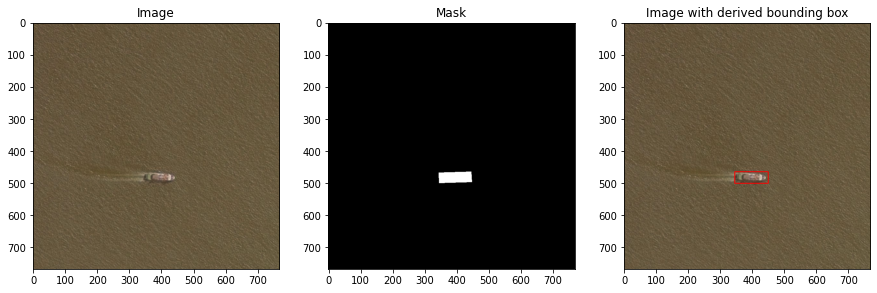

Image 000194a2d.jpg
Found bbox (377, 67, 0, 387, 85, 1)
Found bbox (174, 258, 0, 185, 306, 1)
Found bbox (178, 331, 0, 197, 370, 1)
Found bbox (287, 469, 0, 307, 492, 1)


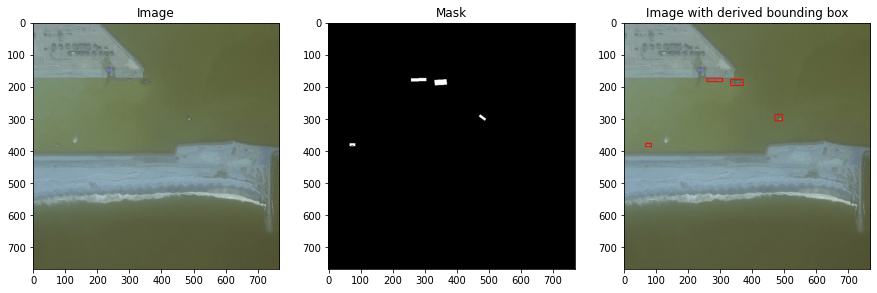

Image 00021ddc3.jpg
Found bbox (705, 96, 0, 720, 121, 1)
Found bbox (732, 123, 0, 768, 178, 1)
Found bbox (629, 181, 0, 638, 187, 1)
Found bbox (661, 195, 0, 665, 201, 1)


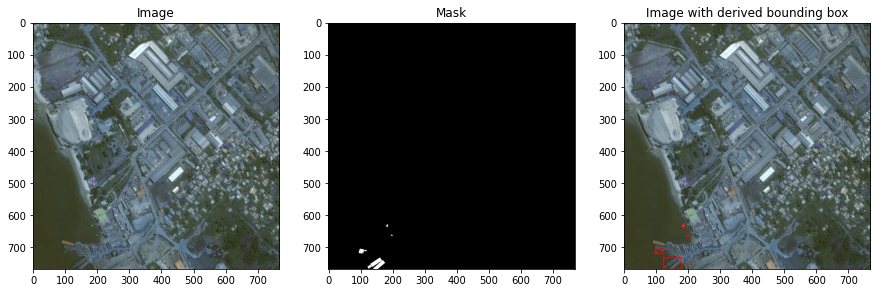

Image 0002756f7.jpg
Found bbox (36, 324, 0, 67, 351, 1)


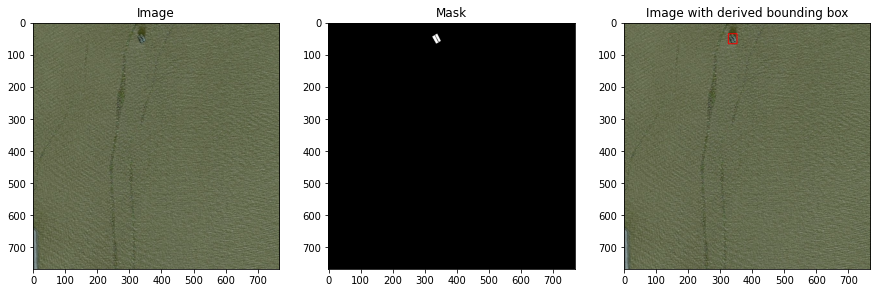

Image 00031f145.jpg
Found bbox (124, 443, 0, 153, 472, 1)


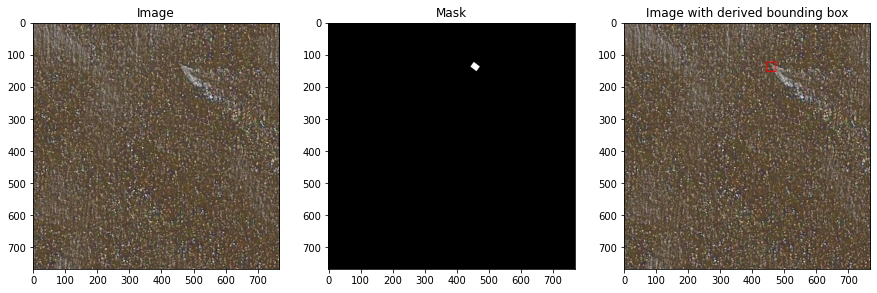

Image 000532683.jpg
Found bbox (460, 597, 0, 474, 604, 1)
Found bbox (756, 738, 0, 763, 747, 1)


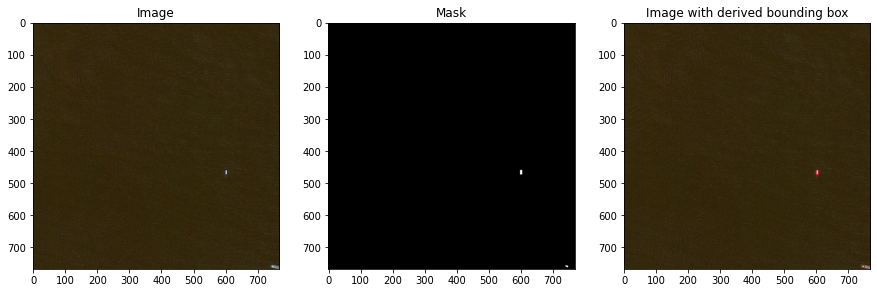

Image 00053c6ba.jpg
Found bbox (124, 736, 0, 139, 752, 1)


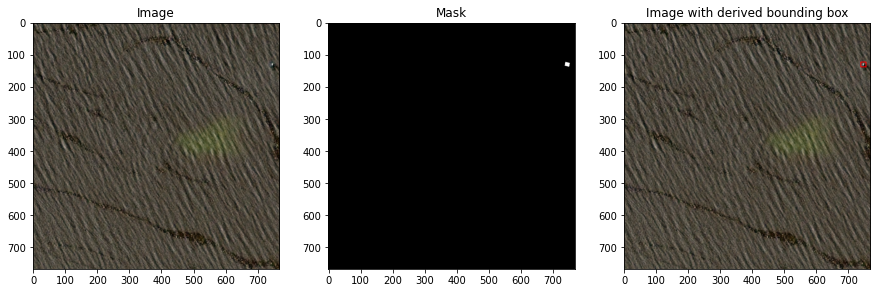

Image 0005d01c8.jpg
Found bbox (598, 72, 0, 739, 237, 1)
Found bbox (252, 476, 0, 321, 556, 1)


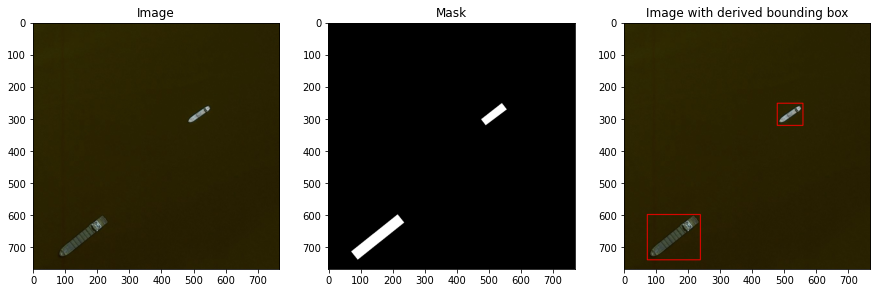

Image 0005d6d95.jpg
Found bbox (171, 345, 0, 190, 367, 1)


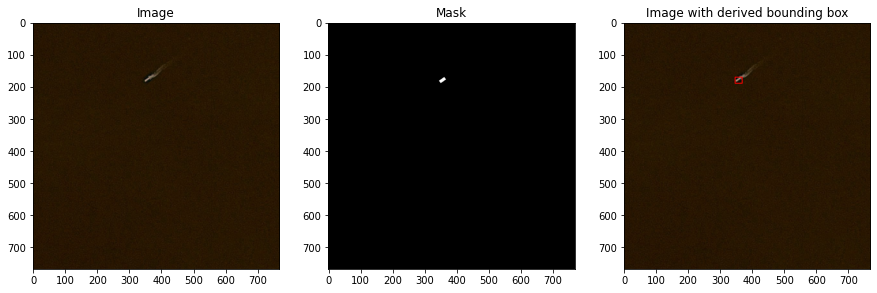

Image 0006c52e8.jpg
Found bbox (197, 190, 0, 472, 407, 1)


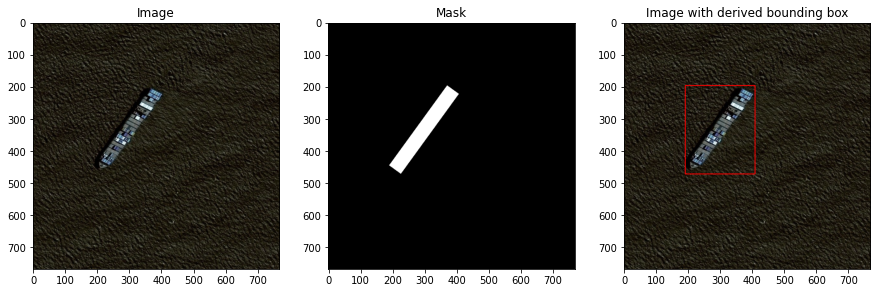

In [11]:
for i in range(10):
    image = images_with_ship[i]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
    img_0 = cv2.imread(train_image_dir+'/' + image)
    rle_0 = masks.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0)
    #
    # 
    lbl_0 = label(mask_0) 
    props = regionprops(lbl_0)
    img_1 = img_0.copy()
    print ('Image', image)
    for prop in props:
        print('Found bbox', prop.bbox)
        cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[4], prop.bbox[3]), (255, 0, 0), 2)


    ax1.imshow(img_0)
    ax1.set_title('Image')
    ax2.set_title('Mask')
    ax3.set_title('Image with derived bounding box')
    ax2.imshow(mask_0[...,0], cmap='gray')
    ax3.imshow(img_1)
    plt.show()

In [29]:
s3_bucket_name="weteh-data-repo-us-east-2"
object_detection_location_prefix = "airbus-object-detection"
train_input_dir = "train_v2"
manifest_prefix = "manifest"

In [64]:
import json
import jsonlines
with jsonlines.open('/mnt/deep_learning/airbus_object_detection_manifest.jsonl', mode='w') as writer:
    for image in images_with_ship:
#         image = images_with_ship[i]
    #     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
        img_0 = cv2.imread(train_image_dir+'/' + image)
        rle_0 = masks.query('ImageId=="'+image+'"')['EncodedPixels']
        mask_0 = masks_as_image(rle_0)
        lbl_0 = label(mask_0) 
        props = regionprops(lbl_0)
        img_1 = img_0.copy()
#         print ('Image', image)
        manifest_obj = {}
        manifest_obj["source-ref"] = "s3://{}/{}/{}/{}".format(s3_bucket_name, object_detection_location_prefix, train_input_dir, image)
        image_size = [{ "width": 768, "height": 768, "depth": 3 }]
        annotations = []
        manifest_obj["bounding-box"] = {}
        manifest_obj["bounding-box"]['image_size'] = image_size
        manifest_obj["bounding-box"]['annotations'] = annotations
        manifest_obj["bounding-box-metadata"] = {}
        objects = []
        manifest_obj["bounding-box-metadata"]['objects'] = objects
        class_map = { "1" : "boat" }
        manifest_obj["bounding-box-metadata"]['class-map'] = class_map
        manifest_obj["bounding-box-metadata"]["type"] = "groundtruth/object-detection"
        manifest_obj["bounding-box-metadata"]["human-annotated"] = "no"
        manifest_obj["bounding-box-metadata"]["creation-date"] = "2020-05-26 02:53:27"
        for prop in props:
            annotation = {}
            annotation['class_id'] = 1
            annotation['top'] = prop.bbox[0]
            annotation['left'] = prop.bbox[1]
            annotation['width'] = prop.bbox[4] - prop.bbox[1]
            annotation['height'] = prop.bbox[3] - prop.bbox[0]
            annotations.append(annotation)
            object = {}
            object['confidence'] = 1
            objects.append(object)
    #         print('Found bbox', prop.bbox)
#         print(json.dumps(manifest_obj))
        idx += 1
        writer.write(manifest_obj)


In [65]:
images_with_no_ship = masks.ImageId[masks.EncodedPixels.isnull()==True]
images_with_no_ship = np.unique(images_with_no_ship.values)
print('There are ' +str(len(images_with_no_ship)) + ' image files with no ships')

There are 150000 image files with no ships


In [66]:
with jsonlines.open('/mnt/deep_learning/airbus_object_detection_manifest_noship.jsonl', mode='w') as writer:
    for image in images_with_no_ship[0:10000]:
        manifest_obj = {}
        manifest_obj["source-ref"] = "s3://{}/{}/{}/{}".format(s3_bucket_name, object_detection_location_prefix, train_input_dir, image)
        image_size = [{ "width": 768, "height": 768, "depth": 3 }]
        annotations = []
        manifest_obj["bounding-box"] = {}
        manifest_obj["bounding-box"]['image_size'] = image_size
        manifest_obj["bounding-box"]['annotations'] = annotations
        manifest_obj["bounding-box-metadata"] = {}
        objects = []
        manifest_obj["bounding-box-metadata"]['objects'] = objects
        class_map = { "0" : "background" }
        manifest_obj["bounding-box-metadata"]['class-map'] = class_map
        manifest_obj["bounding-box-metadata"]["type"] = "groundtruth/object-detection"
        manifest_obj["bounding-box-metadata"]["human-annotated"] = "no"
        manifest_obj["bounding-box-metadata"]["creation-date"] = "2020-05-26 02:53:27"
        for prop in props:
            annotation = {}
            annotation['class_id'] = 0
            annotation['top'] = 0
            annotation['left'] = 0
            annotation['width'] = 768
            annotation['height'] = 768
            annotations.append(annotation)
            object = {}
            object['confidence'] = 1
            objects.append(object)
        writer.write(manifest_obj)
